# Лабораторная №7

In [11]:
import numpy as np
import copy

args = {
    'a': 0,
    'b': 0,
    'c': 2,
    'd': 1,
    'lx': np.pi / 2,
    'ly': np.pi / 2,
    'w': 1.5,
    'Function': lambda x, y: 0,
    'alpha1': 0,
    'alpha2': 1,
    'beta1': 0,
    'beta2': 1,
    'gamma1': 0,
    'gamma2': 1,
    'delta1': 0,
    'delta2': 1,
    'Phi1': lambda y: np.cos(y),
    'Phi2': lambda y: 0,
    'Phi3': lambda x: np.cos(x),
    'Phi4': lambda x: 0,
    'AnaliticalSolution': lambda x, y: np.cos(x) * np.cos(y),
    'algorithm': 'SimpleIterationMethodRelaxed',
    'nx': 10,
    'ny': 10,
    'maxIterNum': 10000,
    'eps': 1e-6
}

In [12]:
class ElepticalSolver:
    def __init__(self, args):
        for name, value in args.items():
            setattr(self, name, value)
        functionName = args['algorithm']
        self.hx = 0
        self.hy = 0
        self.iteration = 0
        try:
            self.FunctionName = getattr(self, functionName)
        except:
            raise Exception("Данный тип не поддерживается, выберите Simple Iteration Method, Seidel или Simple Iteration Method Relaxed")

    def GetCurrentAccurancy(self):
        res = 0
        for i in range(self.nx):
            for j in range(self.ny):
                res = max(res, abs(self.u[i][j] - self.L[i][j]))
        return res

    def UPrepare(self):
        self.u = np.zeros((len(self.x), len(self.y)))
        for i in range(len(self.y)):
            self.u[0][i] = self.Phi1(self.y[i]) / self.alpha2
            self.u[-1][i] = self.Phi2(self.y[i]) / self.beta2
        for i in range(len(self.x)):
            self.u[i][0] = self.Phi3(self.x[i]) / self.gamma2
            self.u[i][-1] = self.Phi4(self.x[i]) / self.delta2

    def Solve(self):
        self.hx = self.lx / self.nx
        self.hy = self.ly / self.ny
        self.x = np.arange(0, self.lx + self.hx, self.hx)
        self.y = np.arange(0, self.ly + self.hy, self.hy)
        self.UPrepare()
        for i in range(1, self.nx):
            for j in range(1, self.ny):
                self.u[i][j] = self.u[0][j] + (self.x[i] - self.x[0]) * (self.u[-1][j] - self.u[0][j]) / (self.x[-1] - self.x[0])
        return self.FunctionName()

    def AnaliticalSolutionMatrix(self):
        self.hx = self.lx / self.nx
        self.hy = self.ly / self.ny
        self.x = np.arange(0, self.lx + self.hx, self.hx)
        self.y = np.arange(0, self.ly + self.hy, self.hy)
        self.u = []
        for yi in self.y:
            self.u.append([self.AnaliticalSolution(xi, yi) for xi in self.x])
        return self.u

    def SimpleIterationMethod(self):
        currentAccurancy = 1e9
        while self.iteration < self.maxIterNum:
            self.L = copy.deepcopy(self.u)
            self.UPrepare()
            for j in range(1, len(self.y) - 1):
                for i in range(1, len(self.x) - 1):
                    self.u[i][j] = (self.hx * self.hx * self.Function(self.x[i], self.y[j]) - (self.L[i + 1][j] + self.L[i - 1][j]) - self.d * self.hx * self.hx * (self.L[i][j + 1] + self.L[i][j - 1]) / (self.hy * self.hy) - self.a * self.hx * 0.5 * (self.L[i + 1][j] - self.L[i - 1][j]) - self.b * self.hx * self.hx * (self.L[i][j + 1] - self.L[i][j - 1]) / (2 * self.hy)) / (self.c * self.hx * self.hx - 2 * (self.hy * self.hy + self.d * self.hx * self.hx) / (self.hy * self.hy))
            previousAccurancy = currentAccurancy
            currentAccurancy = self.GetCurrentAccurancy()
            if self.GetCurrentAccurancy() <= self.eps:# or previousAccurancy < currentAccurancy:
                break
            self.iteration += 1
        return self.u, self.iteration

    def Seidel(self):
        currentAccurancy = 1e9
        while self.iteration < self.maxIterNum:
            self.L = copy.deepcopy(self.u)
            self.UPrepare()
            for j in range(1, len(self.y) - 1):
                for i in range(1, len(self.x) - 1):
                    self.u[i][j] = ((self.hx ** 2) * self.Function(self.x[i], self.y[j]) - (self.L[i + 1][j] + self.u[i - 1][j]) - self.d * (self.hx ** 2) * (self.L[i][j + 1] + self.u[i][j - 1]) / (self.hy ** 2) - self.a * self.hx * 0.5 * (self.L[i + 1][j] - self.u[i - 1][j]) - self.b * (self.hx ** 2) * (self.L[i][j + 1] - self.u[i][j - 1]) / (2 * self.hy)) / (self.c * (self.hx ** 2) - 2 * (self.hy ** 2 + self.d * (self.hx ** 2)) / (self.hy ** 2))
            previousAccurancy = currentAccurancy
            currentAccurancy = self.GetCurrentAccurancy()
            if currentAccurancy <= self.eps:# or previousAccurancy < currentAccurancy:
                break
            self.iteration += 1
        return self.u, self.iteration

    def SimpleIterationMethodRelaxed(self):
        currentAccurancy = 1e9
        while self.iteration < self.maxIterNum:
            self.L = copy.deepcopy(self.u)
            self.UPrepare()
            for j in range(1, len(self.y) - 1):
                for i in range(1, len(self.x) - 1):
                    self.u[i][j] = (((self.hx ** 2) * self.Function(self.x[i], self.y[j]) - (self.L[i + 1][j] + self.u[i - 1][j]) - self.d * (self.hx ** 2) * (self.L[i][j + 1] + self.u[i][j - 1]) / (self.hy ** 2) - self.a * self.hx * 0.5 * (self.L[i + 1][j] - self.u[i - 1][j]) - self.b * (self.hx ** 2) * (self.L[i][j + 1] - self.u[i][j - 1]) / (2 * self.hy)) / (self.c * (self.hx ** 2) - 2 * (self.hy ** 2 + self.d * (self.hx ** 2)) / (self.hy ** 2))) * self.w + (1 - self.w) * self.L[i][j]
            previousAccurancy = currentAccurancy
            currentAccurancy = self.GetCurrentAccurancy()
            if self.GetCurrentAccurancy() <= self.eps:# or previousAccurancy < currentAccurancy:
                break
            self.iteration += 1
        return self.u, self.iteration

In [13]:
algorithms = ('SimpleIterationMethod', 'Seidel', 'SimpleIterationMethodRelaxed')
args['nx'] = 20
args['ny'] = 20

answers = dict()
solver = ElepticalSolver(args)
analytic = solver.AnaliticalSolutionMatrix()
answers['Analytic'] = analytic
for algorithm in algorithms:
    args['algorithm'] = algorithm
    solver = ElepticalSolver(args)
    numeric = solver.Solve()
    answers[algorithm] = numeric


In [14]:
for algorithm in algorithms:
    print(f'{algorithm}: {answers[algorithm][1]} итераций.')

SimpleIterationMethod: 798 итераций.
Seidel: 434 итераций.
SimpleIterationMethodRelaxed: 158 итераций.


<Figure size 640x480 with 0 Axes>

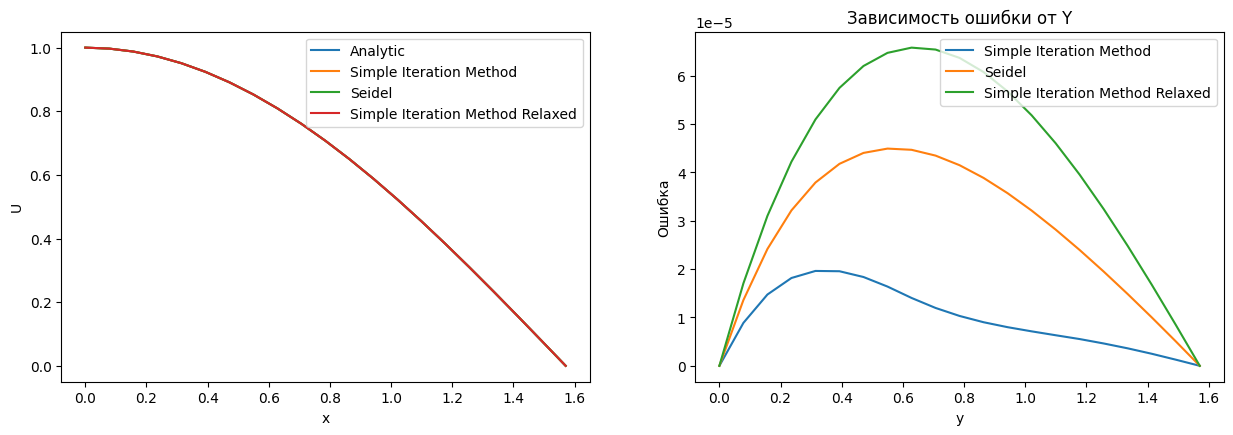

In [15]:
import matplotlib.pyplot as plt

def GetError(numeric, analytic):
    err = []
    error = [[abs(i - j) for i, j in zip(x, y)] for x, y in zip(numeric, analytic)]
    for i in range(len(error)):
        tmp = 0
        for j in error[i]:
            tmp += j
        err.append(tmp / len(error[i]))
    return err

def Draw2DCharts(answers, args, time=0):
    fig = plt.figure()
    x = np.arange(0, np.pi / 2 + np.pi / 2 / args['nx'], np.pi / 2 / args['nx'])
    y = np.arange(0, np.pi / 2 + np.pi / 2 / args['ny'], np.pi / 2 / args['ny'])
    z1 = np.array(answers['Analytic'])
    z2 = np.array(answers['SimpleIterationMethod'][0])
    z3 = np.array(answers['Seidel'][0])
    z4 = np.array(answers['SimpleIterationMethodRelaxed'][0])


    figure = plt.figure(figsize=(15, 10))
    axes = figure.add_subplot(221)
    plt.plot(x, z1[time], label='Analytic')
    plt.plot(x, z2[time], label='Simple Iteration Method')
    plt.plot(x, z3[time], label='Seidel')
    plt.plot(x, z4[time], label='Simple Iteration Method Relaxed')
    plt.legend(loc='best')
    plt.ylabel('U')
    plt.xlabel('x')

    axes = figure.add_subplot(222)
    plt.title('Зависимость ошибки от Y')
    plt.plot(y, GetError(answers['SimpleIterationMethod'][0], answers['Analytic']), label='Simple Iteration Method')
    plt.plot(y, GetError(answers['Seidel'][0], answers['Analytic']), label='Seidel')
    plt.plot(y, GetError(answers['SimpleIterationMethodRelaxed'][0], answers['Analytic']), label='Simple Iteration Method Relaxed')
    plt.legend(loc='best')
    plt.ylabel('Ошибка')
    plt.xlabel('y')
    plt.show()


Draw2DCharts(answers, args)